In [1]:
# %load_ext autoreload
# %autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import  transforms
import matplotlib.pyplot as plt
from dataset import RadarDataset
import cv2
from torchsummary import summary

In [2]:
transform = transforms.ToTensor()

radar_data = RadarDataset(root="./data/2019-01-10-14-36-48-radar-oxford-10k-partial", transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=radar_data, batch_size=12, shuffle=True)

torch.Size([1, 400, 942])
tensor([[[0.0235, 0.0235, 0.1294,  ..., 0.0902, 0.1176, 0.1098],
         [0.1059, 0.1059, 0.1333,  ..., 0.0980, 0.0863, 0.0745],
         [0.0980, 0.0980, 0.1451,  ..., 0.0980, 0.1176, 0.1059],
         ...,
         [0.1137, 0.1137, 0.1451,  ..., 0.0941, 0.0667, 0.0588],
         [0.0588, 0.0588, 0.1373,  ..., 0.1765, 0.1569, 0.1176],
         [0.0784, 0.0784, 0.1294,  ..., 0.1255, 0.0980, 0.0549]]])


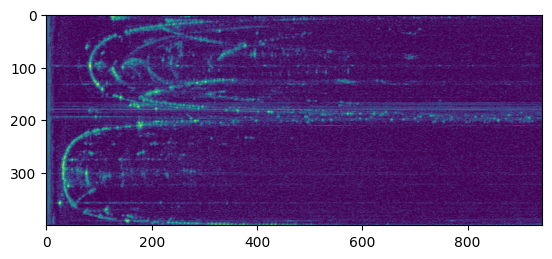

tensor(0.) tensor(0.5333)


In [3]:
dataiter = iter(data_loader)
images = next(dataiter)
print((images[0].size()))
print(images[0])
plt.imshow(images[0][0])
plt.show()
print(torch.min(images), torch.max(images))

In [4]:
class AE(nn.Module):
  def __init__(self):
    super().__init__()
      
    # Building an convolutional encoder with Conv2d
    # layer followed by Relu activation function
    # N, 1, 400, 942
    self.encoder = nn.Sequential(
      nn.Conv2d(1, 16, 3, stride=2, padding=1), # N, 16, 200, 471
      nn.ReLU(),
      nn.Conv2d(16, 32, 3, stride=2, padding=(1,0)), # N, 32, 100, 235
      nn.ReLU(),
      nn.Conv2d(32, 64, (7,10), stride=(4,5), padding=(3,5)) # N, 64, 25, 116
    )
      
    # Building an linear decoder with Linear
    # layer followed by Relu activation function
    # The Sigmoid activation function
    # outputs the value between 0 and 1
    # 9 ==> 784
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(64, 32, (7,10), stride=(4,5), output_padding=(1,0), padding=(2,5)), # N, 32, 7, 7
      nn.ReLU(),
      # We add some padding?
      nn.ConvTranspose2d(32, 16, 3, stride=2, padding=(1,0), output_padding=(1,0)), # N, 16, 14, 14
      nn.ReLU(),
      nn.ConvTranspose2d(16, 1, 3, stride=2, padding=(1,1), output_padding=(1,1)), # N, 1, 28, 28
      nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [5]:
model = AE()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
summary(model, (1,400,942))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 200, 471]             160
              ReLU-2         [-1, 16, 200, 471]               0
            Conv2d-3         [-1, 32, 100, 235]           4,640
              ReLU-4         [-1, 32, 100, 235]               0
            Conv2d-5           [-1, 64, 25, 48]         143,424
   ConvTranspose2d-6         [-1, 32, 100, 235]         143,392
              ReLU-7         [-1, 32, 100, 235]               0
   ConvTranspose2d-8         [-1, 16, 200, 471]           4,624
              ReLU-9         [-1, 16, 200, 471]               0
  ConvTranspose2d-10          [-1, 1, 400, 942]             145
          Sigmoid-11          [-1, 1, 400, 942]               0
Total params: 296,385
Trainable params: 296,385
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.44
Forward/

In [9]:
num_epochs = 10
outputs = []
for epoch in range (num_epochs):
  for (img) in data_loader:
    recon = model(img)
    loss = criterion(recon, img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")
  outputs.append((epoch, img, recon))

Epoch: 1, Loss: 0.0054
Epoch: 2, Loss: 0.0057
Epoch: 3, Loss: 0.0052
Epoch: 4, Loss: 0.0055
Epoch: 5, Loss: 0.0057
Epoch: 6, Loss: 0.0057
Epoch: 7, Loss: 0.0054
Epoch: 8, Loss: 0.0055
Epoch: 9, Loss: 0.0052
Epoch: 10, Loss: 0.0056


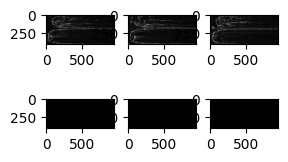

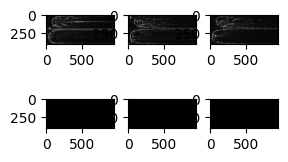

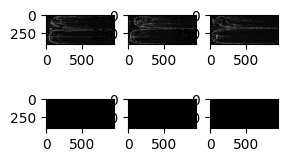

In [10]:
for k in range(0, num_epochs, 4):
  plt.figure(figsize=(3,2))
  plt.gray()
  imgs = outputs[k][1].detach().numpy()
  recon = outputs[k][2].detach().numpy()
  for i, item in enumerate(imgs):
    if i >= 3: break
    plt.subplot(2, 3, i+1)
    plt.imshow(item[0])

  for i, item in enumerate(recon):
    if i >= 3: break
    plt.subplot(2, 3, 3+i+1)
    item = item.reshape(-1, 400, 942)
    plt.imshow(item[0])

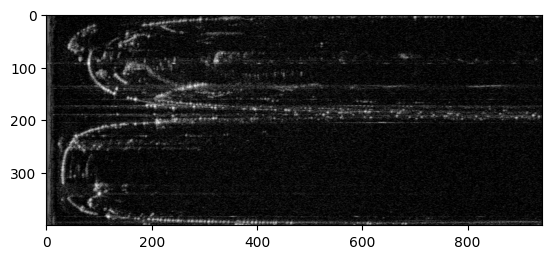

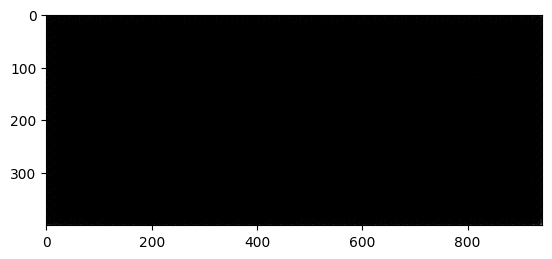

In [15]:
plt.imshow(outputs[9][1][0][0].detach().numpy())
plt.show()
plt.imshow(outputs[9][2][0][0].detach().numpy())